In [20]:
from pynq.overlays.base import BaseOverlay

import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np
import ipywidgets as ipw

# Initialize the RFSoC overlay
base = BaseOverlay('base.bit')

base.init_rf_clks()

base.radio.transmitter.channel[0].dac_block.MixerSettings['Freq'] = 1240 # MHz

base.radio.transmitter.channel[0].control.gain = 0.5
base.radio.transmitter.channel[0].control.enable = True



number_samples = 220
cdata = []
cdata.append(base.radio.receiver.channel[2].transfer(number_samples))

sample_frequency = 2500e6 #Hz
figs = []

In [21]:
import plotly.graph_objs as go
import numpy as np
import ipywidgets as ipw

def plot_complex_time(data, n=number_samples, fs=sample_frequency, 
                      title='Complex Time Plot'):
    plt_re_temp = (go.Scatter(x = np.arange(0, n/fs, 1/fs),
                              y = np.real(data), name='Real'))
    plt_im_temp = (go.Scatter(x = np.arange(0, n/fs, 1/fs),
                              y = np.imag(data), name='Imag'))
    return go.FigureWidget(data = [plt_re_temp, plt_im_temp],
                           layout = {'title': title, 
                                     'xaxis': {
                                         'title': 'Seconds (s)',
                                         'autorange' : True},
                                     'yaxis': {
                                         'title': 'Amplitude (V)'}})

In [22]:
tfigs = []

tfigs.append(plot_complex_time(
        data=cdata[0], 
        title=''.join(['Time Domain Plot of ADC Channel ', str(2), ' Before Downconversion'])))

In [23]:
# Downconvert
# Get rid of samples from cdata[0] so we only have one sample per period
downsample_factor = 20  # Adjust as needed
downsampled_signal = signal.decimate(cdata[0], downsample_factor)

In [24]:
tfigs.append(plot_complex_time(
        data=downsampled_signal, 
        title=''.join(['Time Domain Plot of ADC Channel ', str(2), ' After DownConversion'])))

ipw.VBox(tfigs)

    'data': [{'name': 'Real',
              'type': 'scatter',
              'ui…

In [25]:
window = np.array(np.blackman(number_samples)[:])
# print("window:", window)
# print("cdata:", cdata[0])

downsample_window = np.array(np.blackman(number_samples/downsample_factor)[:])
# print("window:", window)
# print("cdata:", cdata[0])

wdata = []
wfigs = []
wdata.append(cdata[0]*window)
# print("wdata:", wdata[0])
wfigs.append(plot_complex_time(
        data=wdata[0], 
        title=''.join(['Windowed Plot of ADC Channel ', str(2), ' Before Downconversion'])))

wdata.append(downsampled_signal*downsample_window)
wfigs.append(plot_complex_time(
        data=wdata[1], 
        title=''.join(['Windowed Plot of ADC Channel ', str(2), ' After Downconversion'])))

ipw.VBox(wfigs)

    'data': [{'name': 'Real',
              'type': 'scatter',
              'ui…

In [26]:
# Filter the signal (low-pass filter) NOT WORKING
filtered_signal = np.convolve(downsampled_signal, np.ones(int(sample_frequency * T))/sample_frequency, mode='valid')
ffigs = []
ffigs.append(plot_complex_time(
        data=filtered_signal, 
        title=''.join(['Time Domain Plot of ADC Channel ', str(2), ' After Filtering & Downconversion'])))

ipw.VBox(ffigs)

    'data': [{'name': 'Real',
              'type': 'scatter',
              'ui…

In [27]:
fdata = []
for i in range(0, len(wdata)):
    fdata.append(np.fft.fftshift(np.fft.fft(wdata[i])))

In [28]:
def plot_complex_spectrum(data, N=number_samples, fs=sample_frequency, 
                          title='Complex Spectrum Plot', units='dBW', fc=0):
    plt_temp = (go.Scatter(x = np.arange(-fs/2, fs/2, fs/N) + fc,
                           y = data, name='Spectrum'))
    return go.FigureWidget(data = plt_temp,
                           layout = {'title': title, 
                                     'xaxis': {
                                         'title': 'Frequency (Hz)',
                                         'autorange': True},
                                     'yaxis': {
                                         'title': units}})

magfigs = []
for i in range(0, len(fdata)):
    magfigs.append(plot_complex_spectrum(
            data=abs(fdata[i]),
            title=''.join(['Frequency Magnitude Plot of ADC Channel ', str(i+2)]),
            units='|Y(f)|',
            fc=round(abs(base.radio.receiver.channel[0].adc_block.MixerSettings['Freq']))*1e6))

ipw.VBox(magfigs)

    'data': [{'name': 'Spectrum',
              'type': 'scatter',
             …

Length of decoded binary: 11
Decoded binary: [0 0 0 0 0 0 0 1 1 0 0]
Received hex: 0xc


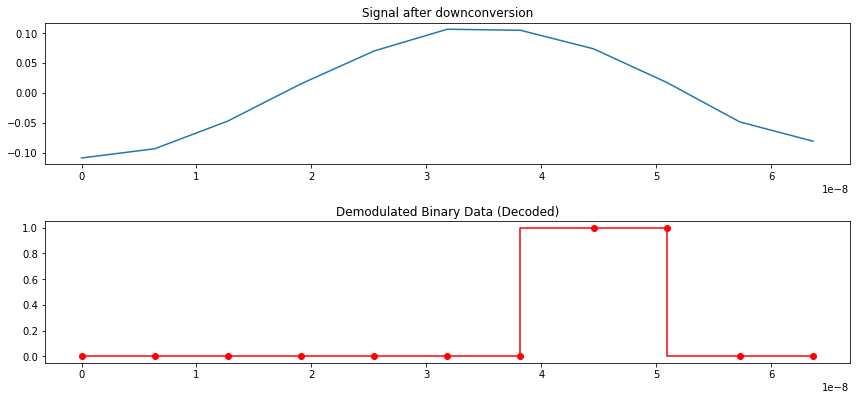

In [30]:
# Parameters
fs = sample_frequency # Sampling frequency
fc = 1240e6 # Carrier frequency
T = 70e-9   # Symbol duration (seconds)
bits_per_symbol = 1

t_dem = np.arange(0, (bits_per_symbol * T), T/11)

# Display signal before downconversion




# Display signal after downconversion
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(t_dem, downsampled_signal.imag)
plt.title('Signal after downconversion')

# BPSK Demodulation

# print("t_dem:", t_dem)
# print(np.size(t_dem))
pre_demodulation_signal = downsampled_signal.imag * np.cos(2 * np.pi * fc * t_dem)
# print("Demodulated_signal:", demodulated_signal)

# Display demodulated signal before filtering
# plt.figure(figsize=(12, 8))
# plt.subplot(3, 1, 1)
# plt.plot(t_dem, demodulated_signal)
# plt.title('Downconverted signal (Before Filtering)')



# Display demodulated signal after filtering
# plt.figure(figsize=(12, 8))
# plt.subplot(3, 1, 2)
# plt.plot(t_dem, demodulated_signal_filtered)
# plt.title('BPSK Demodulated Signal (After Filtering)')

# Decision Threshold (assuming perfect synchronization)
threshold = 0
binary_decoded = (pre_demodulation_signal > threshold).astype(int)

# Plot the demodulated binary signal
plt.subplot(3, 1, 2)
plt.plot(t_dem[:len(binary_decoded)], binary_decoded, 'ro-', drawstyle='steps-pre')
plt.title('Demodulated Binary Data (Decoded)')

# Convert binary data to hex for display
hex_received = hex(int(''.join(map(str, binary_decoded)), 2))

# Print hex values

print("Length of decoded binary:", len(binary_decoded))
print("Decoded binary:", binary_decoded)
print("Received hex:", hex_received)

# message = ''
# message2 = ''
# i = int(len(binary_decoded) // (bits_per_symbol * 2))
# while i < len(binary_decoded):
#     message += str(binary_decoded[i])
#     if str(binary_decoded[i]) == '1':
#         message2 += '0'
#     else:
#         message2 += '1'
#     i += (len(binary_decoded) // bits_per_symbol)
    
#print(message)
#print(message2)



plt.tight_layout()
plt.show()


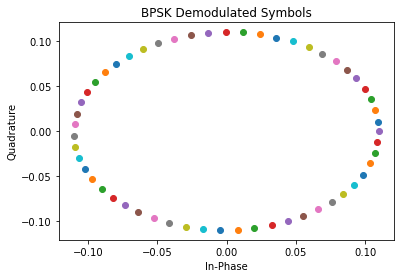

In [14]:
# Downsample the received signal
downsample_factor = 4  # Adjust as needed
downsampled_signal = signal.decimate(cdata, downsample_factor)

# BPSK demodulation
symbol_duration = 1e-6  # Example: 1 microsecond
symbol_samples = int(symbol_duration * sample_frequency)
symbol_indices = np.arange(0, len(downsampled_signal), symbol_samples)

# Extract symbols
symbols = downsampled_signal[symbol_indices]

# BPSK demodulation: multiply with a locally generated carrier
carrier_frequency = 10e6  # Example: 10 MHz
carrier = np.exp(1j * 2 * np.pi * carrier_frequency * np.arange(len(symbols)) / sample_frequency)

demodulated_symbols = symbols * carrier

# Plot the demodulated symbols
plt.plot(np.real(demodulated_symbols), np.imag(demodulated_symbols), 'o')
plt.title('BPSK Demodulated Symbols')
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.show()

In [ ]:
from pynq.overlays.base import BaseOverlay
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# Parameters
fs = 1000  # Sampling frequency
fc = 10  # Carrier frequency
T = 1  # Symbol duration (seconds)
bits_per_symbol = 16

# Initialize the RFSoC overlay
base = BaseOverlay('base.bit')
base.init_rf_clks()

# base.radio.transmitter.channel[0].dac_block.

# # Set the RF transmitter frequency to 1200 MHz
# base.radio.transmitter.channel[0].dac_block.MixerSettings['Freq'] = 1200
# base.radio.transmitter.channel[0].dac_block.QMCSettings

# # Configure the transmitter to a known gain and enable it
# base.radio.transmitter.channel[0].control.gain = 0.5
# base.radio.transmitter.channel[0].control.enable = True

# Generate binary data (0s and 1s)
binary_data = np.random.randint(2, size=bits_per_symbol)

# BPSK Modulation
t_mod = np.arange(0, T, 1/fs)
repeated_binary_data = np.repeat(binary_data, int(np.ceil(len(t_mod) / len(binary_data))))
modulated_signal = np.sqrt(2/T) * np.cos(2 * np.pi * fc * t_mod + np.pi * repeated_binary_data[:len(t_mod)])

# Transmit the modulated signal
# base.radio.transmitter.channel[0].send(modulated_signal)

# Receive the transmitted signal
received_signal = base.radio.receiver.channel[2].transfer(len(modulated_signal))

# BPSK Demodulation
demodulated_signal = received_signal * np.sqrt(2/T) * np.cos(2 * np.pi * fc * t_mod + np.pi)
demodulated_signal_filtered = np.convolve(demodulated_signal, np.ones(int(fs * T))/fs, mode='valid')
# Decision Threshold (assuming perfect synchronization)
threshold = 0
binary_decoded = (demodulated_signal_filtered > threshold).astype(int)
print(len(binary_decoded))
# Convert binary data to hex for display
hex_received = hex(int(''.join(map(str, binary_decoded)), 2))
hex_transmitted = hex(int(''.join(map(str, binary_data)), 2))
# Print hex values
print("Transmitted (hex):", hex_transmitted)
print("Received (hex):", binary_decoded)
print(len(binary_decoded))
message = ''
message2 = ''
i = int(len(binary_decoded) // (bits_per_symbol * 2))
while i < len(binary_decoded):
    message += str(binary_decoded[i])
    if str(binary_decoded[i]) == '1':
        message2 += '0'
    else:
        message2 += '1'
    i += (len(binary_decoded) // bits_per_symbol)
    
print(message)
print(message2)
# Binarize the demodulated signal
decoded_data = (demodulated_signal_filtered > 0).astype(int)

# Calculate the bit error rate (BER)
ber = np.sum(np.abs(binary_data - decoded_data)) / len(binary_data)

# # Print the bit error rate
# print(f"Bit Error Rate (BER): {ber}")

# #Plot the transmitted and received signals
# plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# plt.plot(t_mod, np.real(modulated_signal), label='Transmitted Signal (I)')
# plt.title("Transmitted BPSK Signal")
# plt.legend()

# plt.subplot(2, 1, 2)
# plt.plot(t_mod, np.real(demodulated_signal_filtered), label='Received Signal (I)')
# plt.title("Received and Demodulated BPSK Signal")
# plt.legend()

# plt.tight_layout()
# plt.show()

1
Transmitted (hex): 0xf06f
Received (hex): [0]
1


In [ ]:
import ipywidgets as ipw
from rfsystem.spectrum_sweep import SpectrumAnalyser

analysers = []
sample_frequency = 2457.6e6
number_samples = 12288
for i in [2,3]:
    analysers.append(
        SpectrumAnalyser(channel = base.radio.receiver.channel[i],
                         sample_frequency = sample_frequency,
                         number_samples = number_samples,
                         title = ''.join(['Spectrum Analyser Channel ',
                                          str(i)]),
         MixerSettings               height = None,
                         width = None))

ipw.VBox([analyser.spectrum_plot.get_plot() for analyser in analysers])

In [ ]:
hex_len = len(hex_received)

In [63]:
# Example usage:
received_bits = '';
j = int(hex_len/8)
while j < len(hex_received):
    print(hex_received[j])
    if hex_received[j] == '0':
        received_bits += '0'
    else:
        
        received_bits += '1'
    j += int(hex_len/4)
    
    
print(received_bits)


f
f
0
0
1100


In [32]:
from pynq.overlays.base import BaseOverlay
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# Parameters
fs = 1000  # Sampling frequency
fc = 10  # Carrier frequency
T = 1  # Symbol duration (seconds)
bits_per_symbol = 16

# Initialize the RFSoC overlay
base = BaseOverlay('base.bit')
base.init_rf_clks()

# Set the RF transmitter frequency to 1200 MHz
base.radio.transmitter.channel[0].dac_block.MixerSettings['Freq'] = 1200
base.radio.transmitter.channel[0].dac_block.QMCSettings

# Configure the transmitter to a known gain and enable it
base.radio.transmitter.channel[0].control.gain = 0.5
base.radio.transmitter.channel[0].control.enable = True

# Generate binary data (0s and 1s)
binary_data = np.random.randint(2, size=bits_per_symbol)

# BPSK Modulation
t_mod = np.arange(0, T, 1/fs)
repeated_binary_data = np.repeat(binary_data, int(np.ceil(len(t_mod) / len(binary_data))))
modulated_signal = np.sqrt(2/T) * np.cos(2 * np.pi * fc * t_mod + np.pi * repeated_binary_data[:len(t_mod)])

# Transmit the modulated signal by enabling the control
# (The actual transmission will happen automatically)
# base.radio.transmitter.channel[0].send(modulated_signal)

# Sleep for a duration equal to the transmission time
# (This is just for the sake of this example; you might need to adjust this based on your system)
import time
time.sleep(T * bits_per_symbol)

# Disable the transmitter after transmission is complete
base.radio.transmitter.channel[0].control.enable = False

# Receive the transmitted signal
received_signal = base.radio.receiver.channel[2].transfer(len(modulated_signal))

# Now, you can proceed with demodulation and other processing...
# BPSK Demodulation
demodulated_signal = received_signal * np.sqrt(2/T) * np.cos(2 * np.pi * fc * t_mod + np.pi)
demodulated_signal_filtered = np.convolve(demodulated_signal, np.ones(int(fs * T))/fs, mode='valid')
# Decision Threshold (assuming perfect synchronization)
threshold = 0
binary_decoded = (demodulated_signal_filtered > threshold).astype(int)

# Convert binary data to hex for display
hex_received = hex(int(''.join(map(str, binary_decoded)), 2))
hex_transmitted = hex(int(''.join(map(str, binary_data)), 2))
# Print hex values
print("Transmitted (hex):", hex_transmitted)
print("Received (hex):", hex_received)
print(len(binary_decoded))
message = ''
message2 = ''
i = int(len(binary_decoded) // (bits_per_symbol * 2))
while i < len(binary_decoded):
    message += str(binary_decoded[i])
    if str(binary_decoded[i]) == '1':
        message2 += '0'
    else:
        message2 += '1'
    i += (len(binary_decoded) // bits_per_symbol)
    
print(message)
print(message2)
# Binarize the demodulated signal
decoded_data = (demodulated_signal_filtered > 0).astype(int)

# Calculate the bit error rate (BER)
ber = np.sum(np.abs(binary_data - decoded_data)) / len(binary_data)

# # Print the bit error rate
print(f"Bit Error Rate (BER): {ber}")

# Plot the transmitted and received signals
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t_mod, np.real(modulated_signal), label='Transmitted Signal (I)')
plt.title("Transmitted BPSK Signal")
plt.legend()

plt.subplot(2, 1, 2)
# Plot the received and demodulated signal if applicable
plt.plot(t_mod[:len(demodulated_signal_filtered)], np.real(demodulated_signal_filtered), label='Received Signal (I)')
plt.title("Received and Demodulated BPSK Signal")
plt.legend()

plt.tight_layout()
plt.show()


Transmitted (hex): 0xef66
Received (hex): 0x1
1


KeyboardInterrupt: 

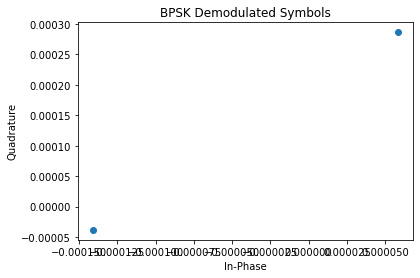

In [33]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import ipywidgets as ipw
from pynq.overlays.base import BaseOverlay

# Initialize the RFSoC overlay
base = BaseOverlay('base.bit')
base.init_rf_clks()

# Parameters
sample_frequency = 1000.6e6
number_samples = 4096

# Capture data from the ADC channel
cdata = base.radio.receiver.channel[2].transfer(number_samples)

# Downsample the received signal
downsample_factor = 4  # Adjust as needed
downsampled_signal = signal.decimate(cdata, downsample_factor)

# BPSK demodulation
symbol_duration = 1e-6  # Example: 1 microsecond
symbol_samples = int(symbol_duration * sample_frequency)
symbol_indices = np.arange(0, len(downsampled_signal), symbol_samples)

# Extract symbols
symbols = downsampled_signal[symbol_indices]

# BPSK demodulation: multiply with a locally generated carrier
carrier_frequency = 10e6  # Example: 10 MHz
carrier = np.exp(1j * 2 * np.pi * carrier_frequency * np.arange(len(symbols)) / sample_frequency)

demodulated_symbols = symbols * carrier

# Plot the demodulated symbols
plt.plot(np.real(demodulated_symbols), np.imag(demodulated_symbols), 'o')
plt.title('BPSK Demodulated Symbols')
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.show()
